# Final - _Due Friday, October 21_
---
## Note: this is the final. It is _not_ a paired programming assignment. **You must complete this lab _on your own_**. 
---
### We'll be exploring the "Airplane Crashes Since 1908" dataset from [Kaggle](http://www.kaggle.com).
### Full history of airplane crashes throughout the world, from 1908-present.
The dataset was downloaded from https://www.kaggle.com/saurograndi/airplane-crashes-since-1908. 

After loading and cleaning the data:

+ **Hypothesis Testing** 
    
+ **Linear Regression**
    
+ **Time Series**

***
## Setup & clean the data
### First, load the packages that will be used in this notebook.

In [50]:
%pylab inline

import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breushpagan
from statsmodels.graphics.correlation import plot_corr
from statsmodels.graphics.regressionplots import plot_leverage_resid2

from sqlalchemy import create_engine
from scipy import stats

random.seed(1234)
sns.set(font_scale=1.5)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Next, load the csv file into a DataFrame and look at the first few lines.

In [10]:
df = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


Here are the variable descriptions (not available in Kaggle website, but from my own understanding of the data):

|Variable|Description|
|:-:|:--|
|**Date**|Date of the accident|
|**Time**|Time of the accident|
|**Location**|Where the accident happened|
|**Operator**|The name of the airline having the accident|
|**Flight#**|The airline flight number|
|**Route**|The location where the flight was bounded|
|**Type**|The type of aircraft that had the accident|
|**Registration**|An alphanumeric string to identify the aircraft|
|**cn/ln**|Serial number of the aircraft|
|**Aboard**|Number of people that was on the aircraft|
|**Fatalities**|The number of fatalities of the total people aboard|
|**Ground**|The distance from the ground when the fatality happened|
|**Summary**|A free text field that summarizes and describes the accident|

Note that the field "Registration" should be unique (per NAA regulations), but after running a SQL query, we found duplicated records.

We can also modify the column names to get rid of periods and spaces. The column names should also be lowercased for use with SQLite.

In [11]:
# Lowercase and replace periods & spaces in the column names
new_names = []

for col in df.columns:
    new_names.append(col.replace('.', '', len(col)).replace(' ', '', len(col)).lower())

df.columns = new_names

print(df.columns)

Index(['date', 'time', 'location', 'operator', 'flight#', 'route', 'type',
       'registration', 'cn/in', 'aboard', 'fatalities', 'ground', 'summary'],
      dtype='object')


In [12]:
df.count()

date            5268
time            3049
location        5248
operator        5250
flight#         1069
route           3562
type            5241
registration    4933
cn/in           4040
aboard          5246
fatalities      5256
ground          5246
summary         4878
dtype: int64

In [13]:
df = df.dropna(axis=0)

In [14]:
df.count()

date            944
time            944
location        944
operator        944
flight#         944
route           944
type            944
registration    944
cn/in           944
aboard          944
fatalities      944
ground          944
summary         944
dtype: int64

We can see that the above numeric variables (aboard, fatalities, ground) have missing data (per NaN values), so will create a new dataset without missing values.

In [15]:
# Date column is not datetime format, so we format it appropiately.
df['date'] = pd.to_datetime(df['date'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944 entries, 208 to 5265
Data columns (total 13 columns):
date            944 non-null datetime64[ns]
time            944 non-null object
location        944 non-null object
operator        944 non-null object
flight#         944 non-null object
route           944 non-null object
type            944 non-null object
registration    944 non-null object
cn/in           944 non-null object
aboard          944 non-null float64
fatalities      944 non-null float64
ground          944 non-null float64
summary         944 non-null object
dtypes: datetime64[ns](1), float64(3), object(9)
memory usage: 103.2+ KB


In [17]:
df.insert(1,'year', df['date'].apply(lambda x: x.year))
df.insert(2,'month', df['date'].apply(lambda x: x.month))
df.insert(3,'dayofweek', df['date'].apply(lambda x: x.dayofweek))
df.insert(4,'hour', df['time'].str[:2])

In [18]:
df.head()

,date,year,month,dayofweek,hour,time,location,operator,flight#,route,type,registration,cn/in,aboard,fatalities,ground,summary
208,1930-01-19,1930,1,6,18,18:23,"Oceanside, California",Maddux Airlines,7,"Aqua Caliente, Mexico - Los Angeles",Ford 5-AT-C Tri Motor,NC9689,5-AT-046,16.0,16.0,0.0,"While en route to Los Angeles, the pilot, flyi..."
236,1931-03-31,1931,3,1,10,10:45,"Bazaar, Kansas",Trans Continental and Western Air,599,Kansas City - Wichita - Los Angeles,Fokker F10A Trimotor,NC-999,1063,8.0,8.0,0.0,"Shortly after taking off from Kansas City, one..."
334,1934-08-31,1934,8,4,23,23:42,"Amazonia, Missouri",Rapid Air Transport,6,Omaha - St. Joseph,Stinson SM-6000B,NC10809,5004,5.0,5.0,0.0,The plane crashed about 11 miles from St. Jose...
354,1935-05-06,1935,5,0,03,03:30,"Atlanta, Missouri",Trans Continental and Western Air,6,Los Angeles - Albuquerque - Kanasas City - Wa...,Douglas DC-2-112,NC13785,1295,14.0,5.0,0.0,The plane crashed while en route from Albuquer...
365,1935-08-14,1935,8,2,23,23:45,"Near Gilmer, Texas",Delta Air Lines,4,Dallas - Atlanta,Stinson Model A,NC14599,9103,4.0,4.0,0.0,Crashed 3 miles south of Gilmer. The outboard ...


## Hypothesis Testing

We will be using a significance level of 0.05

In [19]:
antonov_df = df[df['type'].str[:3] == ('Ant')]

In [20]:
airbus_df = df[df['type'].str[:6] == ('Airbus')]

In [21]:
boeing_df = df[df['type'].str[:6] == ('Boeing')]

#### The aircraft manufacturer Antonov claims the fatalities in their airplanes is less than 22 passengers.

We want to know if the number of fatalities is more than 22.

$H_0: \mu <= 22$

$H_a: \mu > 22$

$t_{stat} = \frac{\bar{X} - \mu_0}{s/ \sqrt{n}} $

In [22]:
t_stat_antonov = (antonov_df.fatalities.mean() - 22)/(antonov_df.fatalities.std()/len(antonov_df)**0.5)
t_stat_antonov

1.1952265304572087

In [23]:
p_value_antonov = stats.t(len(antonov_df)-1).cdf(t_stat_antonov)
p_value_antonov

0.87472304369831599

The p-value is more than 0.05, therefore, we fail to reject the null hypothesis. There's no enough evidence to support that the fatalities in an aircraft manufactured by Antonov is more than 22.

A Type I error would be to claim that the Antonov aircraft have more than 22 fatalities, when they have less.

A Type II error would be to claim that the Antonov aircraft have less than 22 fatalities, when they have more.

#### The aircraft manufacturer Airbus claims the fatalities in their airplanes is less than 20%.

We want to know if the number of fatalities is more than 20%.

$H_0: p <= 20$%

$H_a: p > 20$%

In [24]:
percent_fatalities = airbus_df.fatalities/airbus_df.aboard

In [25]:
z_stat_airbus = (percent_fatalities.mean() - 0.20)/((0.20 * (1 - 0.20)/len(percent_fatalities)))**0.5
z_stat_airbus

5.672359779080775

In [26]:
p_value_airbus = stats.norm.cdf(z_stat_airbus)
p_value_airbus

0.99999999295781039

The p-value is more than 0.05, therefore, we fail to reject the null hypothesis. There's no enough evidence to support that the percentage of fatalities in an aircraft manufactured by Airbus is more than 20%.

A Type I error would be to claim that the Airbus aircraft have more than 20% fatalities, when they have less.

A Type II error would be to claim that the Airbys aircraft have less than 20% fatalities, when they have more.

In [27]:
boeing_average_fatalities = boeing_df.fatalities.mean()
boeing_std_deviation_fatalities = boeing_df.fatalities.std()
boeing_sample = len(boeing_df)
boeing_average_fatalities, boeing_std_deviation_fatalities, boeing_sample

(79.56613756613757, 83.09051790899629, 189)

#### Boeing claims that the average fatalities for their airplanes is more than 60. To test the claim, a random sample of 189 flights showed an average of 75.57 fatalities, with a standard deviation s of 89.09.  The FFA claims that average fatalities for Boeing is 70, what is the power of the test?

In [29]:
print("The power of the test is:",stats.t(189-1).cdf((boeing_average_fatalities - 70)/(boeing_std_deviation_fatalities /189**0.5)))

The power of the test is: 0.942421919705


So probability of rejecting the null hypothesis $H_0$ when the alternative hypothesis $H_a$ is true is 94%.

#### There's no difference in the number of fatalities for aircrafts Airbus and Boeing.

We want to know if they are different.

$H_0: \mu_1 = \mu_2 \text{ or } \mu_1 - \mu_2 = 0$  

$H_a: \mu_1 \neq \mu_2 \text{ or } \mu_1 - \mu_2 \neq 0$

In [30]:
stats.ttest_ind_from_stats(airbus_df.fatalities.mean(),airbus_df.fatalities.std(),airbus_df.fatalities.count(),boeing_df.fatalities.mean(),boeing_df.fatalities.std(),boeing_df.fatalities.count())

Ttest_indResult(statistic=1.3264713131542651, pvalue=0.18608438449452927)

The p-value is more than 0.05, therefore we reject the null hypothesis. There's no enough evidence to conclude that the average fatalities for Airbus and Boeing is different.

### Are the fatalities independent of aircraft type Antonov, Airbus and Boeing?

$H_0$: fatalities are independent from aircraft type (Antonov, Airbus or Boeing).

$H_a$: fatalities are dependent from aircraft type (Antonov, Airbus or Boeing).

In [31]:
accidents_df = pd.DataFrame(index=['Fatalities'], columns=['Antonov','Airbus','Boeing'])
accidents_df.head()

,Antonov,Airbus,Boeing
Fatalities,NaN,NaN,NaN


In [32]:
accidents_df['Antonov'] = [antonov_df.fatalities.sum()]
accidents_df['Airbus'] = [airbus_df.fatalities.sum()]
accidents_df['Boeing'] = [boeing_df.fatalities.sum()]

In [33]:
accidents_df

,Antonov,Airbus,Boeing
Fatalities,469.0,2958.0,15038.0


In [34]:
# In order to pass the dataframe data into stats.chisquare, IT NEEDS TO BE CONVERTED FROM PANDAS
# DATAFRAME INTO NUMPY ARRAY OR LIST.
fatalities_total_array = np.asarray(accidents_df.ix[0,:])
fatalities_total_array

array([   469.,   2958.,  15038.])

In [35]:
expected_fatalities = [accidents_df.sum().sum()/3]*3
expected_fatalities

[6155.0, 6155.0, 6155.0]

In [36]:
stats.chisquare(fatalities_total_array, expected_fatalities)

Power_divergenceResult(statistic=19733.402761982128, pvalue=0.0)

The p-value is less than 0.05, therefore we reject the null hypothesis that aircraft fatalities is independent from the aircraft type (Antonov, Airbus, Boeing).

## Linear Regression

### Simple Regression

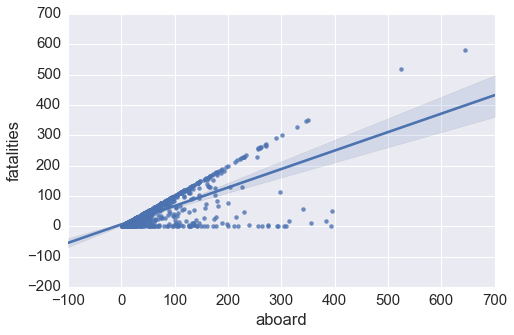

In [116]:
sns.lmplot(x='aboard', y='fatalities', data=df, aspect=1.5);

We can see nonlinearity in the plot.

In [39]:
X_one = df.aboard
X_one = sm.add_constant(X_one)
y_one = df.fatalities

model_one = sm.OLS(y_one, X_one)
results_one = model_one.fit()
results_one.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     1104.
Date:                Sat, 08 Oct 2016   Prob (F-statistic):          7.22e-161
Time:                        18:10:24   Log-Likelihood:                -4825.7
No. Observations:                 944   AIC:                             9655.
Df Residuals:                     942   BIC:                             9665.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.0171      1.747      3.443      0.001         2.588     9.446
aboard         0.6094      0.018     33.231      0.000         0.573     0.645
==============================================================================
Omnibus:                      362.672   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3339.143
Skew:                          -1.492   Prob(JB):                         0.00
Kurtosis:                      11.717   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\hat{fatalities} = 4.3750 + aboard * 0.5989$

#### Interpreting $R^2$:

The percentage of the variation in y (fatalities) can be explained by the corresponding variation in X (passengers aboard) and the least-squares line is 54%, and the unexplained percentage of variation is 100% – 54% = 46%.

#### Interpreting the model:

For every unit of increase of passengers aboard, fatalities increase by 0.6094.

#### Hypothesis testing:

Using a significance level of 0.05.

$H_0: \beta_1 = 0$

$H_a: \beta_1 \neq 0$

The F-statistic of the model is 1104 and the p-value is 7.22e-161. 

Since the p-value is less than 0.05, so reject the null hypothesis and conclude that the coefficient of passengers aboard is significant.

#### Making a prediction of fatalities for all aircrafts with 2,000 passengers aboard:

In [40]:
results_one.predict([1, 2000])

array([ 1224.85578457])

#### The confidence interval for the above prediction is:

In [41]:
x = df.aboard
se = sqrt(results_one.mse_resid)
b0, b1 = results_one.params

x_new = 2000

def confidence_se(s_e, x, x_new):
    mean_x = x.mean()
    var_x = x.var()
    n = len(x)
    return s_e * (1/n + (x_new - mean_x)**2 / ((n - 1) * var_x))**0.5

sign = array([-1., 1.])
b0 + b1 * x_new + sign * 1.96 * confidence_se(se, x, x_new)

array([ 1155.19034085,  1294.5212283 ])

#### The prediction interval for a particular aircraft with 2,000 passengers aboard:

In [42]:
def prediction_se(s_e, x, x_new):
    mean_x = x.mean()
    var_x = x.var()
    n = len(x)
    return s_e * (1 + 1/n + (x_new - mean_x)**2 / ((n - 1) * var_x))**0.5

b0 + b1 * x_new + sign * 1.96 * prediction_se(se, x, x_new)

array([ 1119.67023424,  1330.0413349 ])

For both the given population of all aircrafts with passengers aboard of 2,000, the mean is the same as one aircraft with 2,000 passengers aboard. HOWEVER, the variance for the given population of all aircrafts with passengers aboard of 2,000 is $\sigma^2/n$, when the variance for the one aircraft with 2,000 passengers aboard is $\sigma^2$, which is more than the variance for the given population of all aircrafts with passengers aboard of 2,000. THEREFORE, the confidence interval for the given population of all aircrafts with passengers aboard of 2,000 is smaller than the prediction interval for the one aircraft with 2,000 passengers aboard.

#### Another way of constructing the linear model:

In [43]:
correlation = corrcoef(df.aboard,df.fatalities)

In [44]:
b_1 = correlation[0][1] * (df.fatalities.std()/df.aboard.std())
b_1

0.60941935321163954

In [45]:
b_0 = df.fatalities.mean() - b_1 * df.aboard.mean()
b_0

6.0170781508552764

$\hat{fatalities} = b_0 + b_1 * aboard$

#### Checking residuals

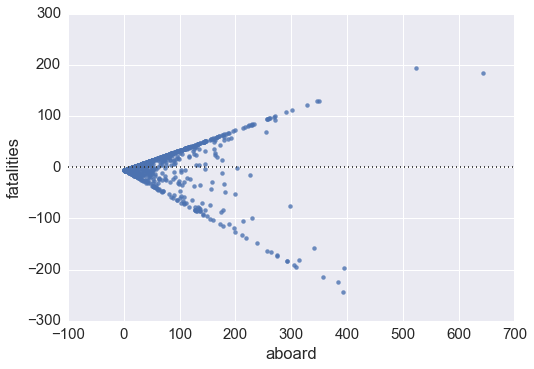

In [90]:
sns.residplot('aboard', 'fatalities', df);

We can see the relationship between the residuals and the predictive variable `aboard`. The non-linearity is more evident here.

#### Test for non-Normality

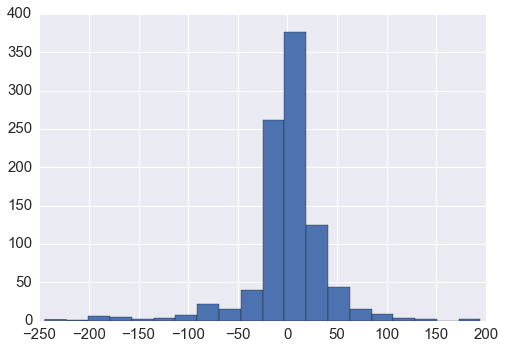

In [54]:
# Histogram of residuals.
res_one = results_one.resid
hist(res_one, bins = 20);

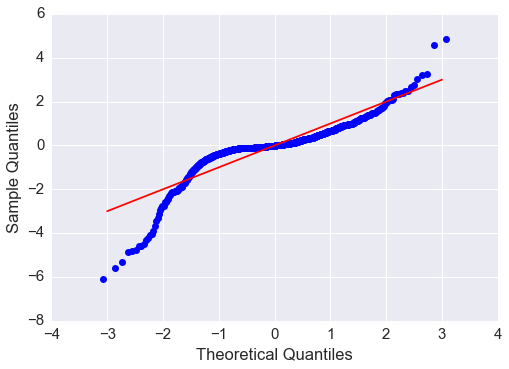

In [51]:
## QQ plot of residuals.
sres_one = results_one.resid_pearson
qqplot(sres_one)
q = linspace(-3, 3)
plot(q, q, color='r');

Non-normality visually confirmed.

Numerical method for Normality.

$H_0$ : data is Normally distributed.

$H_a$: data is not Normally distributed.

A small p-value indicates violation of the Normality assumption.

From the OLS model we get:

Jarque-Bera (JB): 3339.143

Prob(JB): 0.00

The p-value for the Normality test is 0.00, which shows evidence of non-Normality.

#### Test for heteroskedasticity.

Numerical tests for heteroskedasticity.

$H_0$: constant variance

$H_1$: non-constant variance

A small p-value gives evidence for non-constant variance (heteroskedasticity).

In [55]:
het_breushpagan(results_one.resid, results_one.model.exog) # the second output gives the p-value of the test

(547.41601561540119,
 4.5931867731392e-121,
 1300.2690653529414,
 1.3704099389390326e-179)

The p-value of 4.5931867731392e-121 is less than 0.05, therefore we reject non heteroskedasticity.

In [133]:
# Since we have some instances of 0 fatalities and to avoid log(0), we will add 1 to all fatalities.
log_y = np.log(y_one + 1)
model_log = sm.OLS(log_y, X_one)
results_log = model_log.fit()

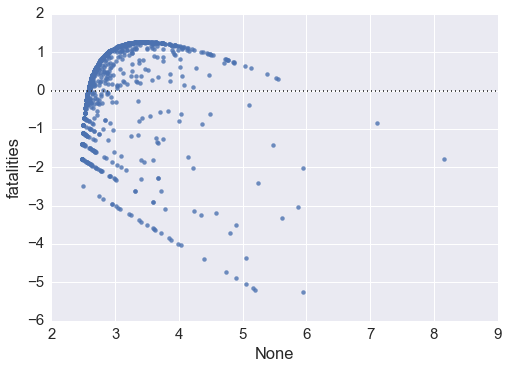

In [134]:
sns.residplot(results_log.fittedvalues, log_y, df);

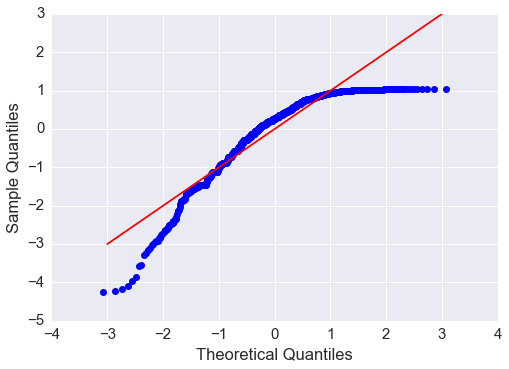

In [135]:
sres_one = results_log.resid_pearson
qqplot(sres_one)
q = linspace(-3, 3)
plot(q, q, color='r');

In [119]:
y_inv = 1/(y_one + 1)
model_inv = sm.OLS(y_inv, X_one)
results_inv = model_inv.fit()

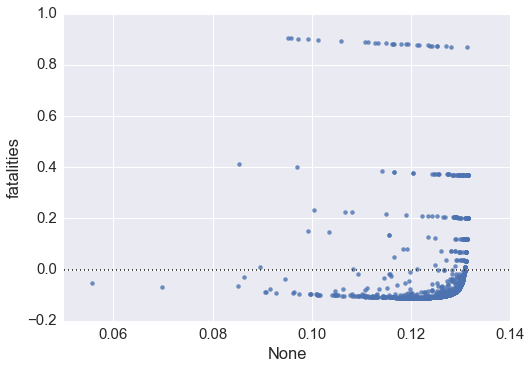

In [120]:
sns.residplot(results_inv.fittedvalues, y_inv, df);

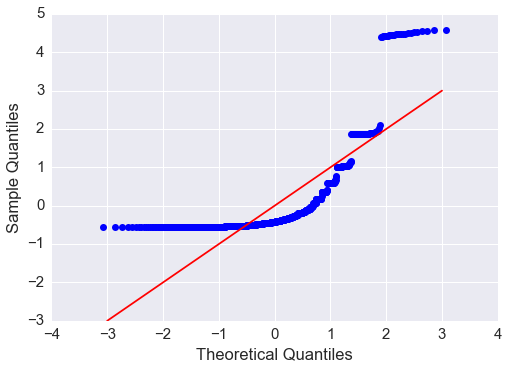

In [132]:
sres_one = results_inv.resid_pearson
qqplot(sres_one)
q = linspace(-3, 3)
plot(q, q, color='r');

In [136]:
y_sqr = y_one**2
model_sqr = sm.OLS(y_sqr, X_one)
results_sqr = model_sqr.fit()

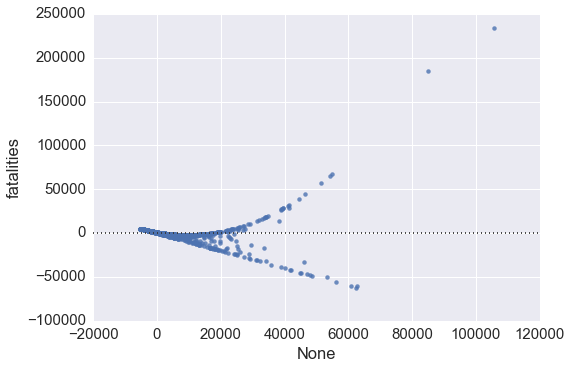

In [137]:
sns.residplot(results_sqr.fittedvalues, y_sqr, df);

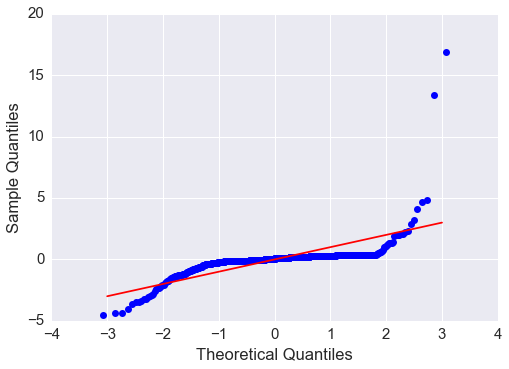

In [138]:
sres_one = results_sqr.resid_pearson
qqplot(sres_one)
q = linspace(-3, 3)
plot(q, q, color='r');

In [139]:
log_y_2 = np.log(y_one + 1)
model_log_2 = sm.OLS(log_y_2, log(X_one))
results_log_2 = model_log_2.fit()

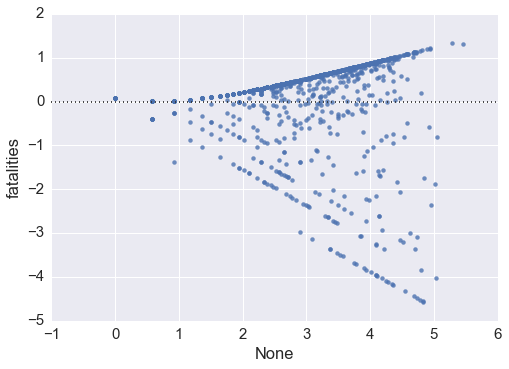

In [140]:
sns.residplot(results_log_2.fittedvalues, log_y_2, df);

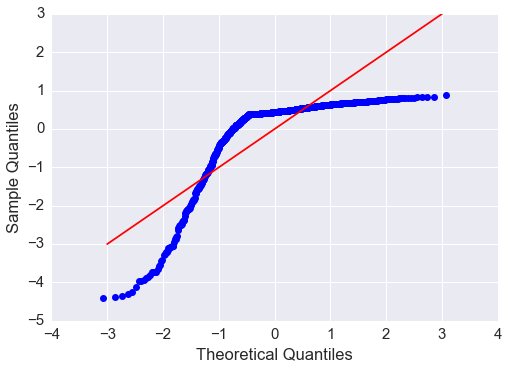

In [141]:
sres_one = results_log_2.resid_pearson
qqplot(sres_one)
q = linspace(-3, 3)
plot(q, q, color='r');

In [142]:
y_2 = y_one
model_log_3 = sm.OLS(y_2, log(X_one))
results_log_3 = model_log_3.fit()

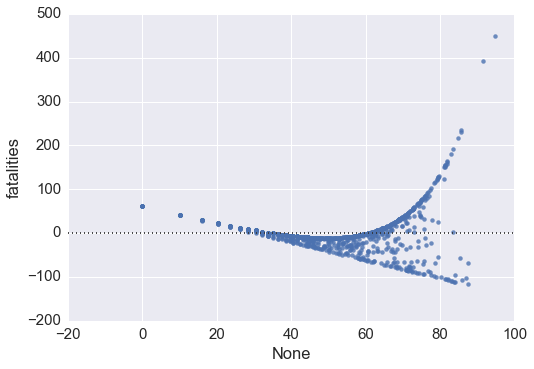

In [143]:
sns.residplot(results_log_3.fittedvalues, y_2, df);

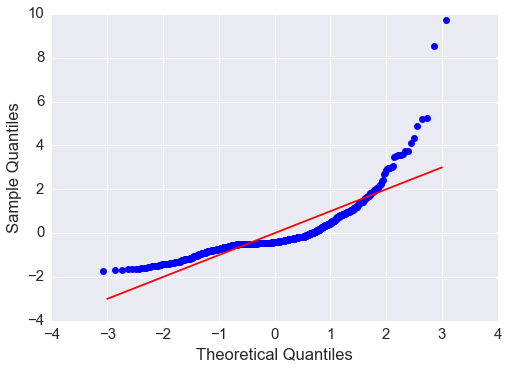

In [144]:
sres_one = results_log_3.resid_pearson
qqplot(sres_one)
q = linspace(-3, 3)
plot(q, q, color='r');

In [145]:
y_2 = y_one
model_log_3 = sm.OLS(y_2, 1/X_one)
results_log_3 = model_log_3.fit()

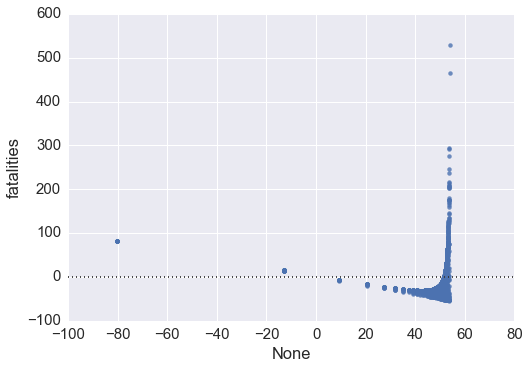

In [146]:
sns.residplot(results_log_3.fittedvalues, y_2, df);

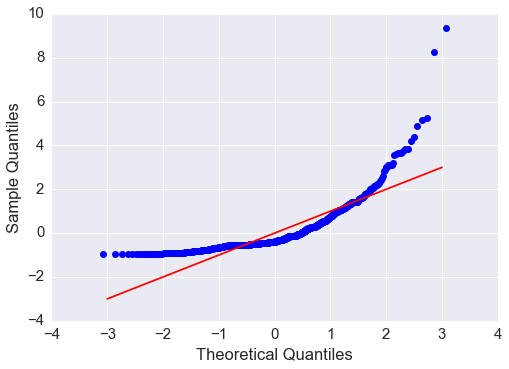

In [147]:
sres_one = results_log_3.resid_pearson
qqplot(sres_one)
q = linspace(-3, 3)
plot(q, q, color='r');

In [148]:
y_2 = y_one
model_log_3 = sm.OLS(y_2, X_one**0.5)
results_log_3 = model_log_3.fit()

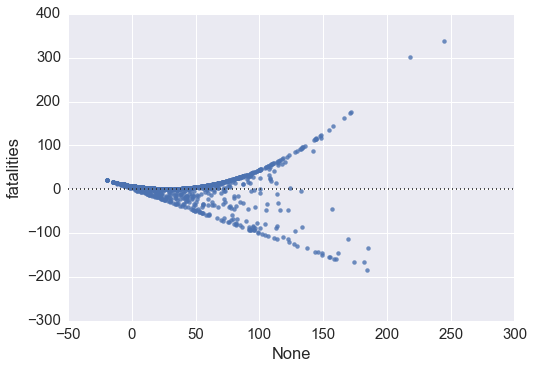

In [149]:
sns.residplot(results_log_3.fittedvalues, y_2, df);

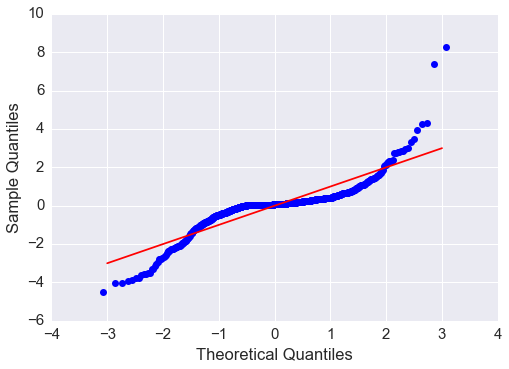

In [150]:
sres_one = results_log_3.resid_pearson
qqplot(sres_one)
q = linspace(-3, 3)
plot(q, q, color='r');

In [151]:
y_2 = y_one
model_log_3 = sm.OLS(y_2, X_one**2)
results_log_3 = model_log_3.fit()

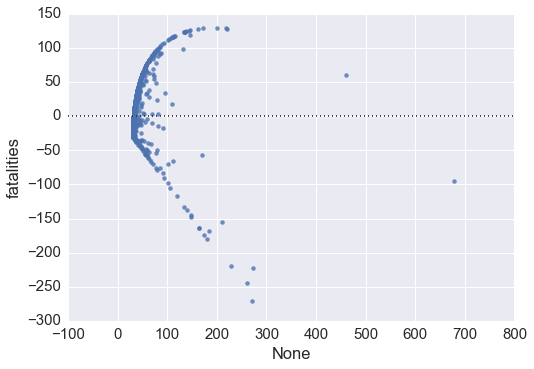

In [152]:
sns.residplot(results_log_3.fittedvalues, y_2, df);

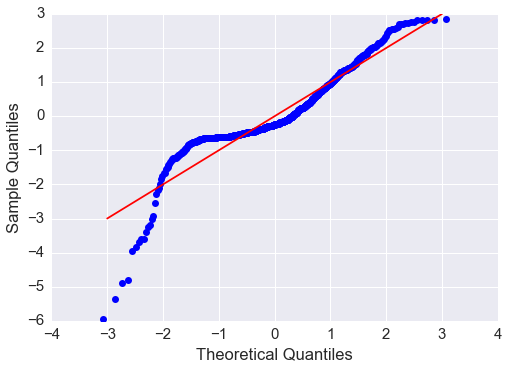

In [153]:
sres_one = results_log_3.resid_pearson
qqplot(sres_one)
q = linspace(-3, 3)
plot(q, q, color='r');

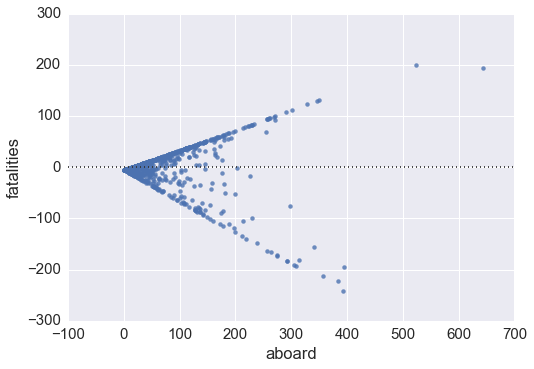

In [97]:
sns.residplot('aboard', 'fatalities', df, order=2);

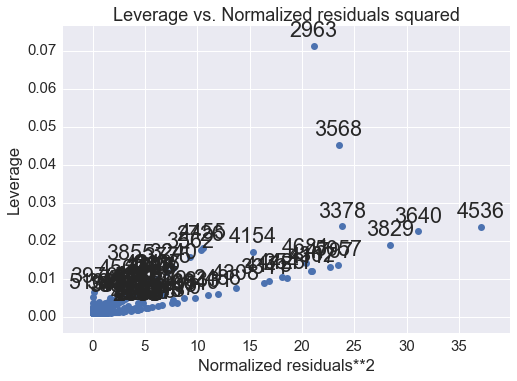

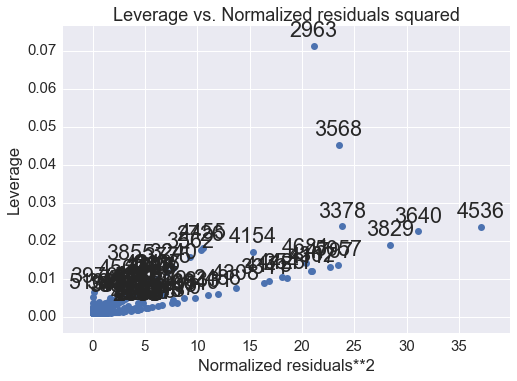

In [103]:
plot_leverage_resid2(results_one)

In [104]:
df_new = pd.DataFrame()
for i in range(2900,4500):
    df_new = df[(df.index != i)]

In [105]:
X_new = df_new.aboard
X_new = sm.add_constant(X_new)
y_new = df_new.fatalities

model_new = sm.OLS(y_new, X_new)
results_new = model_new.fit()
results_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     1104.
Date:                Sat, 08 Oct 2016   Prob (F-statistic):          8.16e-161
Time:                        18:58:22   Log-Likelihood:                -4820.5
No. Observations:                 943   AIC:                             9645.
Df Residuals:                     941   BIC:                             9655.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.0629      1.748      3.469      0.001         2.633     9.493
aboard         0.6094      0.018     33.231      0.000         0.573     0.645
==============================================================================
Omnibus:                      363.124   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3350.131
Skew:                          -1.495   Prob(JB):                         0.00
Kurtosis:                      11.736   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

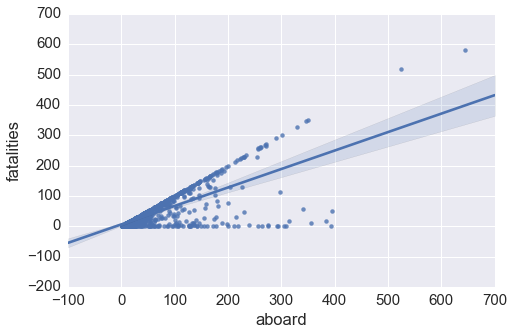

In [106]:
sns.lmplot('aboard', 'fatalities', df_new, aspect=1.5);

### Multiple Regression

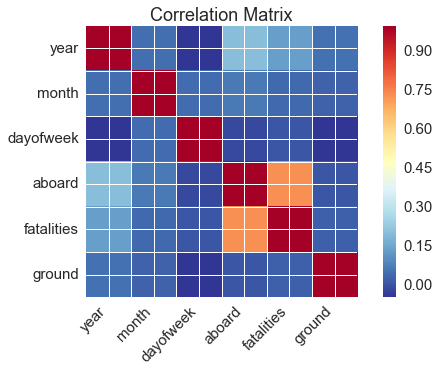

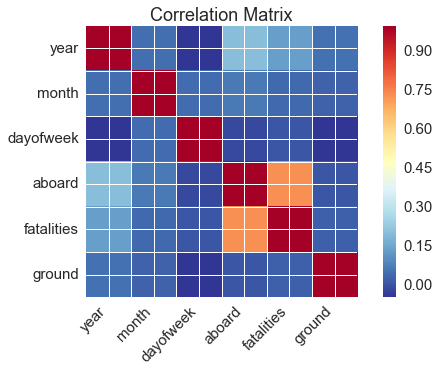

In [117]:
numerics_only = df.select_dtypes(['int64', 'float64'])
sm.graphics.plot_corr(numerics_only.corr(), xnames=numerics_only.columns.tolist())

In [118]:
numerics_only.corr()

,year,month,dayofweek,aboard,fatalities,ground
year,1.000000,0.052456,-0.041120,0.207855,0.142569,0.055780
month,0.052456,1.000000,0.047339,0.073920,0.043106,0.030059
dayofweek,-0.041120,0.047339,1.000000,-0.009206,0.011575,-0.043698
aboard,0.207855,0.073920,-0.009206,1.000000,0.734616,0.010455
fatalities,0.142569,0.043106,0.011575,0.734616,1.000000,0.028327
ground,0.055780,0.030059,-0.043698,0.010455,0.028327,1.000000


In [50]:
X_multi = df[['aboard','ground']]
X_multi = sm.add_constant(X_multi)
y_multi = df['fatalities']

model_multi = sm.OLS(y_multi, X_multi)
results_multi = model_multi.fit()
results_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fatalities   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     2134.
Date:                Thu, 06 Oct 2016   Prob (F-statistic):               0.00
Time:                        14:41:21   Log-Likelihood:                -14243.
No. Observations:                3042   AIC:                         2.849e+04
Df Residuals:                    3039   BIC:                         2.851e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          4.3586      0.568      7.678      0.000         3.246     5.472
aboard         0.5986      0.009     65.267      0.000         0.581     0.617
ground         0.0103      0.007      1.539      0.124        -0.003     0.023
==============================================================================
Omnibus:                     1902.204   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            90171.217
Skew:                          -2.315   Prob(JB):                         0.00
Kurtosis:                      29.267   Cond. No.                         85.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\hat{fatalities} = 4.3586 + aboard * 0.5986 + ground * 0.0103$

#### Interpretation of the overall F test:

F-statistic: 2134
Prob (F-statistic): 0

The overall model is good: the overall p-value is 0.0, which is less than 0.05. Also, the F-statistic is high (2134).

#### Model interpretation:

For every passenger aboard, fatalities increase by 0.5986.

For every feet above the ground, fatalities increase by 0.0103.

#### Interpreting $R^2$:

There's no difference with the model with just one variable.

HOWEVER, the F-statistic of the model with two indepedent variable is less than the model with just one independent variable. ALSO, the p-value of the model with two indepedent variable seems to be higher than the model with just one independent variable: the p-value for the independent variable ground is 0.124, which is greater than 0.05, and therefore it doesn't play a role in the model, so we should discard it.

The model with just one independent variable (passengers aboard) is the best one.